In [ ]:
import numpy as np
import random

In [ ]:
!git clone https://github.com/Alpgirl/DLT.git

Cloning into 'DLT'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 93 (delta 13), reused 38 (delta 5), pack-reused 0
Receiving objects: 100% (93/93), 302.06 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (42/42), done.


In [ ]:
!pip install -r ./DLT/requirements.txt

In [ ]:
from DLT import generation as gn
from DLT.projection.utils import project_points, get_projection_matrix

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

In [ ]:
# define extrinsic parameters
# -------------------------------

# rotate an angle of pi/4 along the standard Y axis
angles = [np.pi/4]
order = 'y'

# transalte by the given offset
offset = np.array([0, -8, 0])

# define intrinsic parameters
# -------------------------------

f = 2   # focal length
s = 0   # skew factor
a = 1   # aspect ratio
cx = 0  # x-offset from the origin center
cy = 0  # y-offset from the origin center
img_size = (10, 10)

In [ ]:
# create extrinsic matrix
# --------------------------

# create rotation transformation matrix
R = gn.create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation transformation matrix
T_ = gn.create_translation_matrix(offset)

E = np.linalg.inv(T_ @ R_)
E = E[:-1, :]

# create intrinsic matrix
# ---------------------------
K = gn.compute_intrinsic_parameter_matrix(f, s, a, cx, cy)

In [ ]:
# choose the lower limit of the points such they're always beyond the image plane

n_points = 1024
rand_points = gn.generate_random_points(n_points, (-10, 0), (-10, 10), (f, 10))

In [ ]:
# create an image grid
xx, yy, Z = gn.create_image_grid(f, img_size)
# convert the image grid to homogeneous coordinates
pt_h = gn.convert_grid_to_homogeneous(xx, yy, Z, img_size)
# transform the homogeneous coordinates
pt_h_transformed = T_ @ R_ @ pt_h
# convert the transformed homogeneous coordinates back to the image grid
xxt, yyt, Zt = gn.convert_homogeneous_to_grid(pt_h_transformed, img_size)

Text(0.5, 0, 'Z-axis')

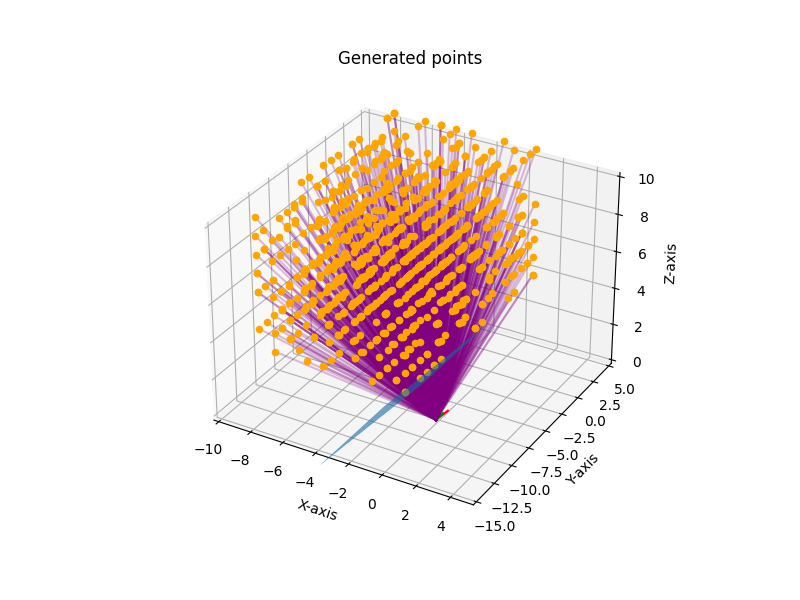

In [ ]:
# define axis and figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-10, 5), ylim=(-15, 5), zlim=(0, 10))

# plot the camera in the world
ax = gn.pr.plot_basis(ax, R, offset)
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)

# plot the generated random points
c = 0
for i in range(n_points):
    point = rand_points[:, c]
    ax.scatter(*point, color="orange")
    ax.plot(*gn.make_line(offset, point), color="purple", alpha=0.25)
    c += 1

ax.set_title("Generated points")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

In [ ]:
plt.savefig('./../genpoints.png')

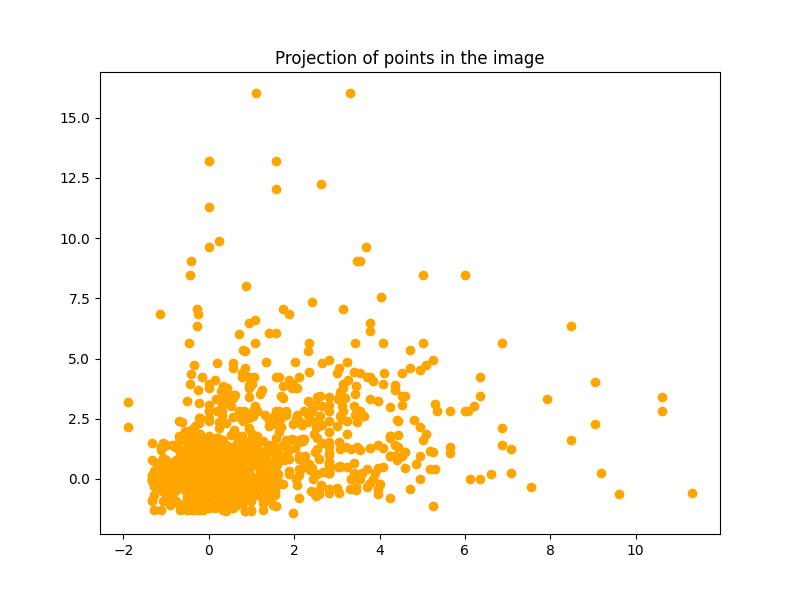

In [ ]:
rand_points_camera = gn.compute_coordinates_wrt_camera(rand_points, E, is_homogeneous=False)
projections = gn.compute_image_projection(rand_points_camera, K)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange")

ax.set_title("Projection of points in the image")
plt.savefig('./../projpoints.png')

In [ ]:
idxs = np.random.choice(np.arange(rand_points.T.shape[0]), size=(6,))
points2d = projections.T[idxs]
points3d = rand_points.T[idxs]

In [ ]:
P_intermidiate = get_projection_matrix(points2d, points3d, optimize=False)
predictions = project_points(P_intermidiate, rand_points.T)
errors = projections.T - predictions
mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
print("Mean reprojection error: ", mean_error)

Mean reprojection error:  4.480235567841942e-15


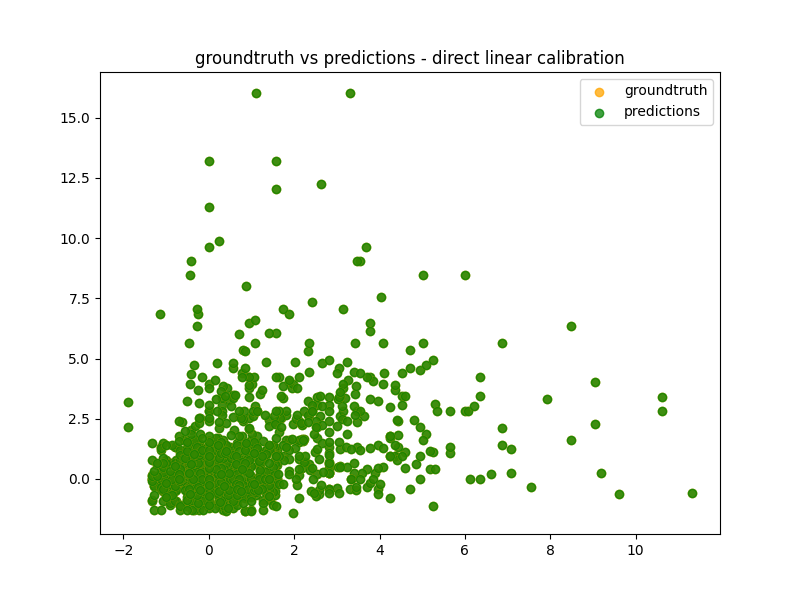

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""

    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*predictions.T.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)

ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()


In [ ]:
plt.savefig('./../groundtruth_vs_predictions.png')

In [ ]:
P_final = get_projection_matrix(points2d, points3d, optimize=True)
predictions_v2 = project_points(P_final, rand_points.T)
errors = projections.T - predictions
mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
print("Mean reprojection error: ", mean_error)

Mean reprojection error:  4.480235567841942e-15


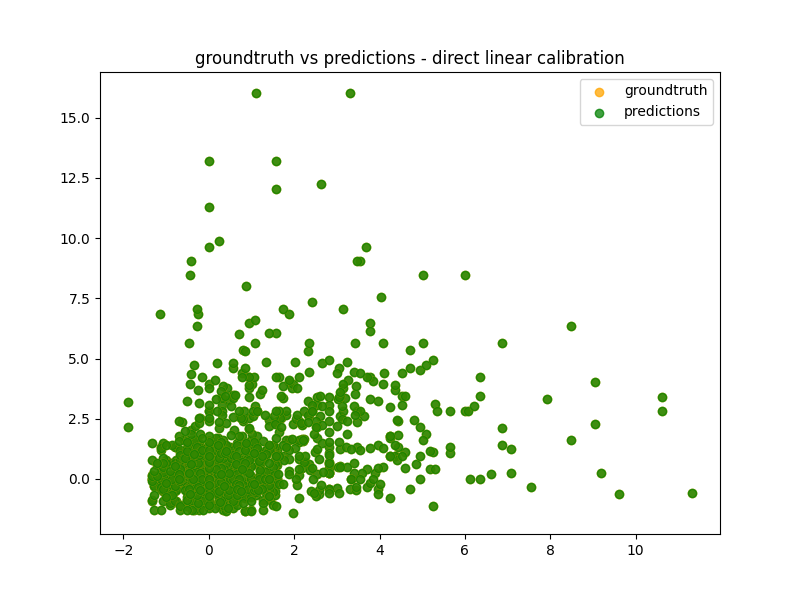

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""

    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*predictions_v2.T.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)

ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()

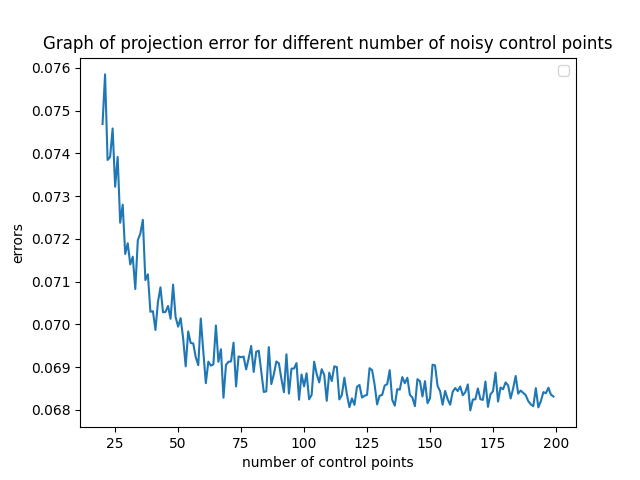

In [ ]:
n = projections.shape[1]
projections_noisy =  projections + np.random.rand(2, n) * 1e-1
rand_points_noisy =  rand_points + np.random.rand(3, n) * 1e-2
total_errors = []
for n in np.arange(20, 200):
    total_errors.append(0)
    for _ in range(100):
        idxs = np.random.choice(np.arange(rand_points_noisy.T.shape[0]), size=(n,))
        points2d = projections_noisy.T[idxs]
        points3d = rand_points_noisy.T[idxs]
        P_intermidiate = get_projection_matrix(points2d, points3d, optimize=False)
        predictions = project_points(P_intermidiate, rand_points.T)
        errors = projections.T - predictions
        mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
        total_errors[-1] += mean_error
    total_errors[-1] /= 100.

plt.figure()
plt.plot(np.arange(20, 200), total_errors)
plt.title('Graph of projection error for different number of noisy control points')
plt.xlabel('number of control points')
plt.ylabel('errors')
plt.legend()
plt.show()

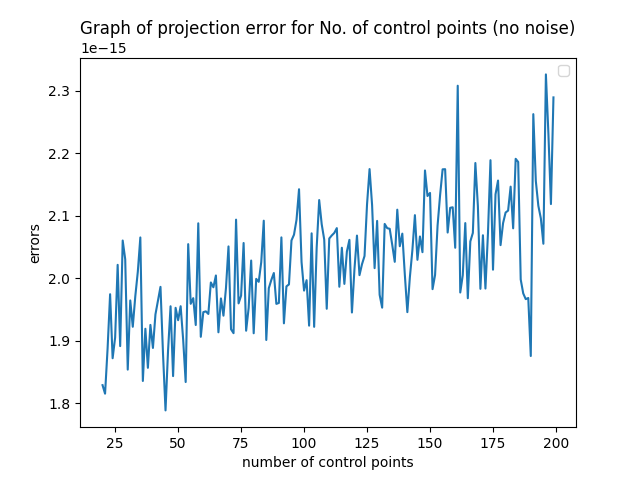

In [ ]:
total_errors = []
for n in np.arange(20, 200):
    total_errors.append(0)
    for _ in range(100):
        idxs = np.random.choice(np.arange(rand_points.T.shape[0]), size=(n,))
        points2d = projections.T[idxs]
        points3d = rand_points.T[idxs]
        P_intermidiate = get_projection_matrix(points2d, points3d, optimize=False)
        predictions = project_points(P_intermidiate, rand_points.T)
        errors = projections.T - predictions
        mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
        total_errors[-1] += mean_error
    total_errors[-1] /= 100.

plt.figure()
plt.plot(np.arange(20, 200), total_errors)
plt.title('Graph of projection error for No. of control points (no noise)')
plt.xlabel('number of control points')
plt.ylabel('errors')
plt.legend()
plt.show()

In [ ]:
n = projections.shape[1]
projections_noisy =  projections + np.random.rand(2, n) * 1e-1
rand_points_noisy =  rand_points + np.random.rand(3, n) * 1e-2
total_errors = []
for n in np.arange(20, 200):
    total_errors.append(0)
    for _ in range(100):
        idxs = np.random.choice(np.arange(rand_points_noisy.T.shape[0]), size=(n,))
        points2d = projections_noisy.T[idxs]
        points3d = rand_points_noisy.T[idxs]
        P_intermidiate = get_projection_matrix(points2d, points3d, optimize=True)
        predictions = project_points(P_intermidiate, rand_points.T)
        errors = projections.T - predictions
        mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
        total_errors[-1] += mean_error
    total_errors[-1] /= 100.

plt.figure()
plt.plot(np.arange(20, 200), total_errors)
plt.title('Graph of projection error for different number of noisy control points (with optimization)')
plt.xlabel('number of control points')
plt.ylabel('errors')
plt.legend()
plt.show()

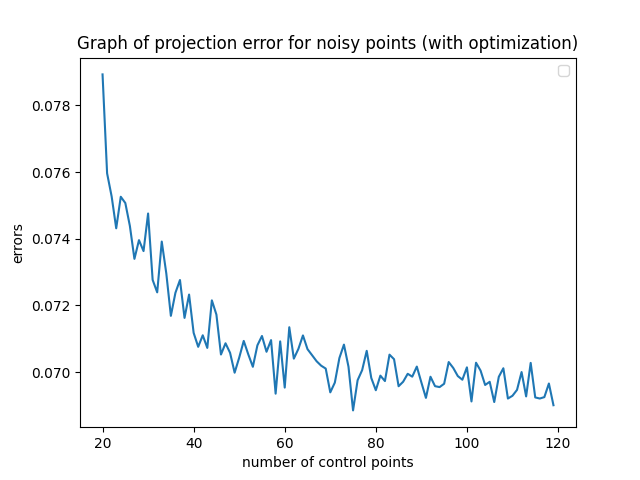

In [ ]:
plt.figure()
plt.plot(np.arange(20, 120), total_errors[:100])
plt.title('Graph of projection error for noisy points (with optimization)')
plt.xlabel('number of control points')
plt.ylabel('errors')
plt.legend()
plt.show()

## Experiments with images

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

points3D_file = "DLT/data/points3D.txt"
images_file = "DLT/data/images.txt"


points2D = dict()
points3D = dict()
Images = dict()


with open(points3D_file, 'r') as file:
    for line in file.readlines()[3:]:
        components = line.split()
        id = int(components[0])

        useful_data = components[1:7]
        useful_data = [float(i) for i in useful_data]
        points3D[id] = useful_data


with open(images_file, 'r') as file:
    step = 0
    current_image = None
    for line in file.readlines()[4: ]:
        components = line.split()
        if step == 0:
            current_image = int(components[0])
            step = 1
            continue
        components = [float(i) for i in components]
        points = list(chunks(components, 3))
        points2D[current_image] = points
        step = 0


for key, value in points2D.items():
    temp = list()
    for point2d in value:
        if point2d[-1] != -1:
            temp.append(point2d[:-1] + points3D[point2d[-1]])
        # else:
        #     temp.append(point2d)
    Images[key] = temp

In [ ]:
# Data source: https://www.eth3d.net/datasets#:~:text=(0.9%20GB)-,boulders,-%2D%2026%20images%20outdoors
# Images have id. The python dictionary "Images" contains all the images(26 in total)
# in the format
# Images[image_id] = list of all points
# list of all points as the format
# x, y, xx, yy, zz, r, g, b

In [ ]:
points = np.array(Images[5])
idxs = np.random.choice(np.arange(points.T.shape[0]), size=(80,))
print(points.shape)
points2d = points[:,:2]
points3d = points[:,2:5]
print(points2d.shape, points3d.shape)
P_final = get_projection_matrix(points2d[idxs], points3d[idxs], optimize=True)
predictions = project_points(P_final, points3d)
errors = (points2d - predictions)/np.mean(points2d)
mean_error = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
print("Mean reprojection error: ", mean_error)

(3219, 8)
(3219, 2) (3219, 3)
Mean reprojection error:  1.2222311509312147


In [ ]:
predictions

array([[-0.15726816,  6.33226337],
       [ 0.3703685 ,  1.20511141],
       [-1.14249626,  0.79919906],
       ...,
       [ 1.99279883,  0.71694386],
       [-0.30938056,  0.76661661],
       [ 2.31183747,  0.44969921]])

In [ ]:
predictions.shape

(1024, 2)

In [ ]:
image_id = 5
image = np.array(Images[image_id])


ValueError: ignored

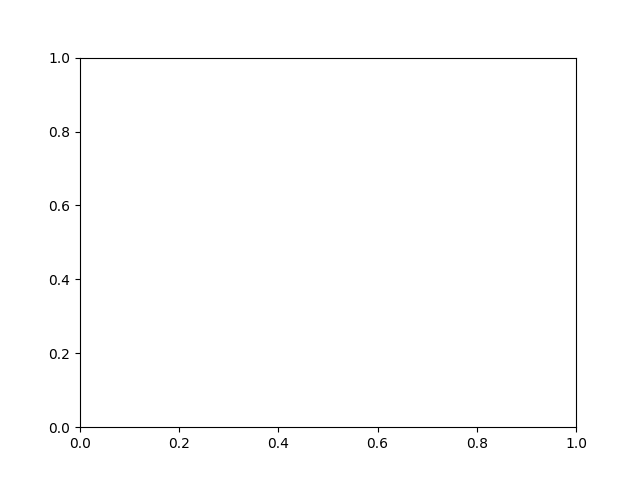

In [ ]:
points = predictions # change to transformed
colors = image[:, 5:] / 255.0

# Create a scatter plot
# plt.scatter(points[:,0], points[:, 1])
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], c=colors)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Points')

# Show the plot
plt.show()

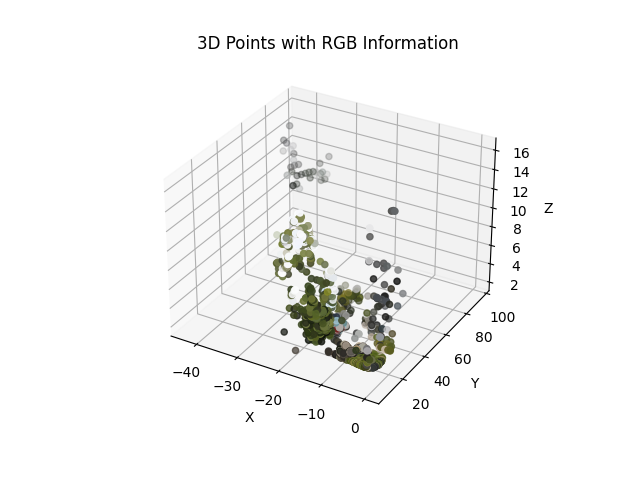

In [ ]:
points = image[:, 2:5] # change to transformed
colors = image[:, 5:] / 255.0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points with RGB Information')

# Show the plot
plt.show()